In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load dataset
data = pd.read_csv('/content/emotions (1).csv')

# Handle missing values and duplicates
print("Missing values before handling:")
print(data.isnull().sum())
data.dropna(inplace=True)
data.drop_duplicates(subset='text', inplace=True)




Missing values before handling:
text     0
label    1
dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Add emotion column using label_map
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
data['emotion'] = data['label'].map(label_map)


# Show class distribution
print("\nClass distribution:")
print(data['label'].value_counts())

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])




Class distribution:
label
1.0    13903
0.0    12143
3.0     5627
4.0     4638
2.0     3334
5.0     1498
Name: count, dtype: int64


In [5]:
# Train-test split
X = data['cleaned_text']
y = data['encoded_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# # TF-IDF Vectorization
# tfidf = TfidfVectorizer(max_features=5000)

# Optimized TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,   # Reduced features
    min_df=5,            # Ignore rare terms
    max_df=0.8,          # Ignore too common terms
    ngram_range=(1, 2),  # Unigrams + Bigrams
    stop_words='english' # Built-in stopword removal
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# # Optional: use only a subset of training data for faster SVM training
X_train_tfidf = X_train_tfidf[:10000]
y_train = y_train[:10000]



Training and evaluating SVM with linear kernel...

SVM with linear kernel:
Accuracy: 0.8616
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      2429
         1.0       0.85      0.93      0.89      2781
         2.0       0.80      0.61      0.70       667
         3.0       0.91      0.82      0.86      1125
         4.0       0.86      0.80      0.83       928
         5.0       0.77      0.73      0.75       299

    accuracy                           0.86      8229
   macro avg       0.84      0.80      0.82      8229
weighted avg       0.86      0.86      0.86      8229



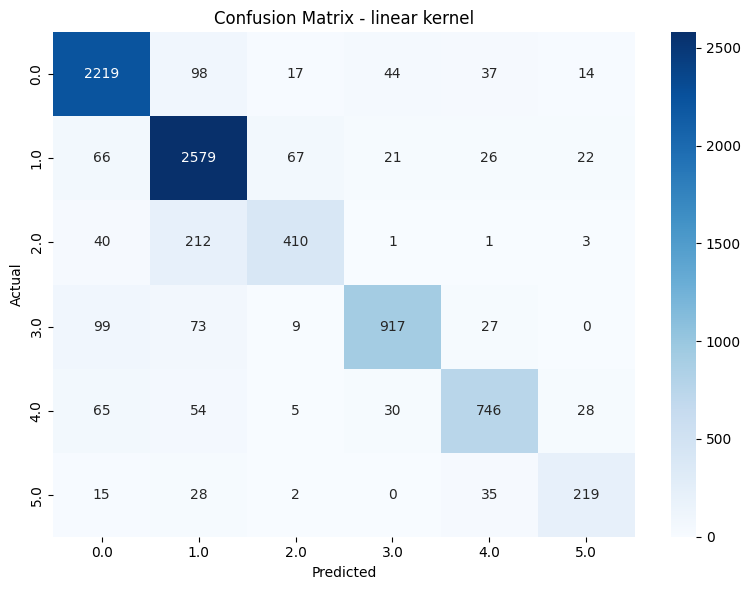


Training and evaluating SVM with poly kernel...

SVM with poly kernel:
Accuracy: 0.6210
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77      2429
         1.0       0.50      0.98      0.66      2781
         2.0       0.94      0.11      0.20       667
         3.0       0.96      0.29      0.44      1125
         4.0       0.94      0.21      0.35       928
         5.0       0.86      0.12      0.22       299

    accuracy                           0.62      8229
   macro avg       0.84      0.41      0.44      8229
weighted avg       0.76      0.62      0.58      8229



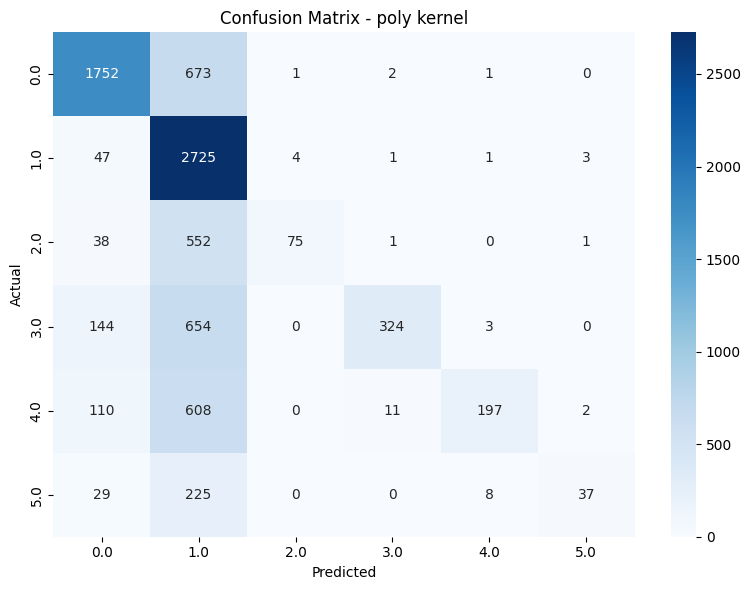


Training and evaluating SVM with rbf kernel...

SVM with rbf kernel:
Accuracy: 0.8340
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      2429
         1.0       0.77      0.95      0.85      2781
         2.0       0.86      0.45      0.59       667
         3.0       0.92      0.75      0.83      1125
         4.0       0.89      0.72      0.80       928
         5.0       0.84      0.47      0.60       299

    accuracy                           0.83      8229
   macro avg       0.86      0.71      0.76      8229
weighted avg       0.84      0.83      0.83      8229



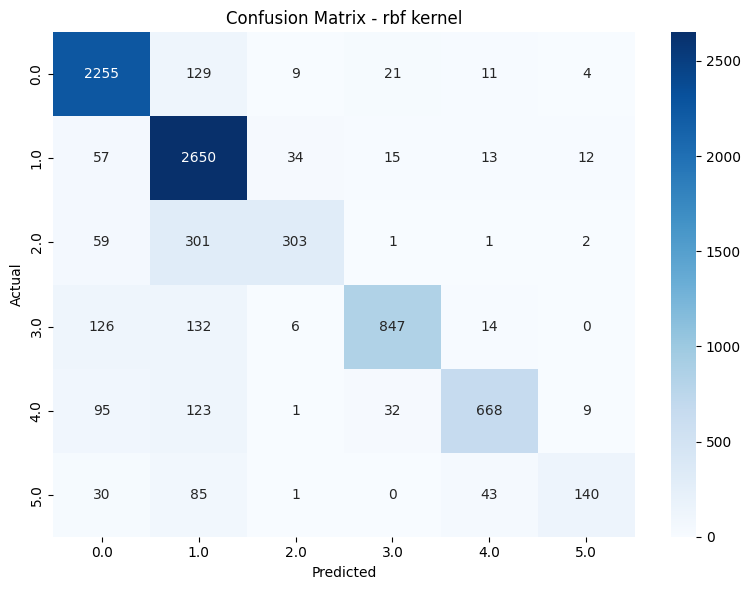


Training and evaluating SVM with sigmoid kernel...

SVM with sigmoid kernel:
Accuracy: 0.8600
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      2429
         1.0       0.84      0.93      0.88      2781
         2.0       0.82      0.60      0.69       667
         3.0       0.90      0.82      0.86      1125
         4.0       0.84      0.81      0.82       928
         5.0       0.76      0.70      0.73       299

    accuracy                           0.86      8229
   macro avg       0.84      0.79      0.81      8229
weighted avg       0.86      0.86      0.86      8229



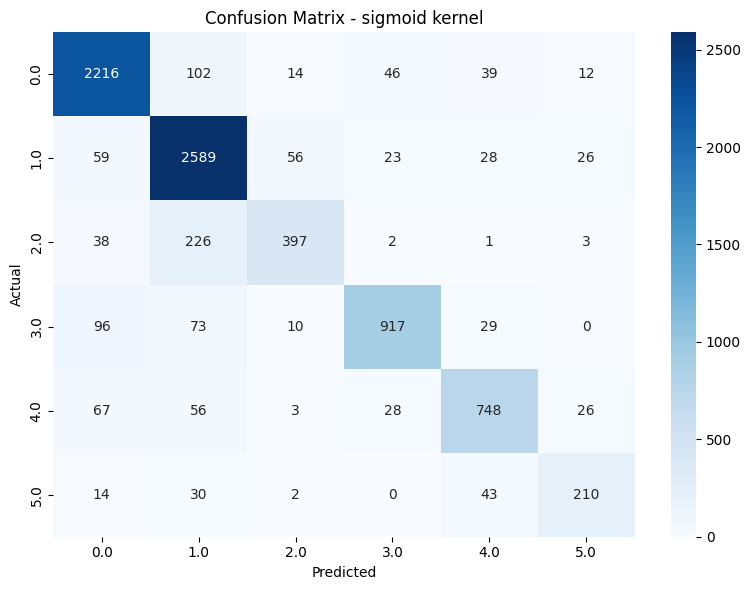

In [6]:

# Function to evaluate SVM with different kernels
def evaluate_svm(kernel_type):
    print(f"\nTraining and evaluating SVM with {kernel_type} kernel...")
    model = SVC(kernel=kernel_type, random_state=42)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report_dict = classification_report(
        y_test, y_pred, target_names=label_encoder.classes_, output_dict=True
    )

    print(f"\nSVM with {kernel_type} kernel:")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {kernel_type} kernel')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return acc, report_dict

# Evaluate kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    accuracy, report = evaluate_svm(kernel)
    results[kernel] = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }



In [7]:
# Kernel performance summary
results_df = pd.DataFrame(results).T
print("\nPerformance comparison across kernels:")
print(results_df)




Performance comparison across kernels:
         accuracy  precision    recall  f1-score
linear   0.861587   0.861122  0.861587  0.859232
poly     0.620975   0.757024  0.620975  0.575183
rbf      0.834002   0.842416  0.834002  0.825604
sigmoid  0.860007   0.859830  0.860007  0.857239


<Figure size 1000x600 with 0 Axes>

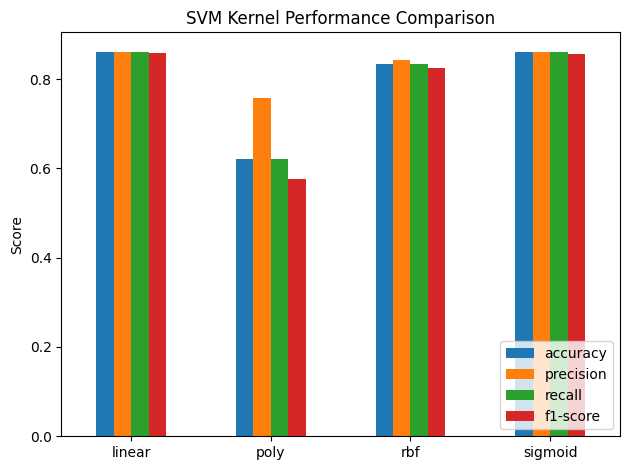

In [8]:
# Plot kernel comparison
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', y=['accuracy', 'precision', 'recall', 'f1-score'],
                title='SVM Kernel Performance Comparison')
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



In [9]:
# Best kernel
best_kernel = results_df['accuracy'].idxmax()
print(f"\nBest performing kernel: {best_kernel}")


Best performing kernel: linear


In [10]:
# Train final model using existing X_train_tfidf and y_train (already vectorized and smaller)
from google.colab import files
import joblib

final_model = SVC(kernel=best_kernel, probability=True, random_state=42)
final_model.fit(X_train_tfidf, y_train)

# Save model, vectorizer, and encoder
joblib.dump(final_model, 'svm_emotion_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Download the files
files.download('svm_emotion_model.pkl')
files.download('tfidf_vectorizer.pkl')
files.download('label_encoder.pkl')

print("\n✅ Optimized model training complete. Files saved and downloaded.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Optimized model training complete. Files saved and downloaded.


In [11]:
# Predict function
def predict_emotion(text):
    text_cleaned = preprocess_text(text)
    text_vector = tfidf.transform([text_cleaned])
    pred_label = final_model.predict(text_vector)[0]
    #emotion = label_encoder.inverse_transform([pred_label])[0]
    emotion = label_map[pred_label]
    return emotion

# 1.Test prediction

sample = input("Enter text to predict emotion: ")
print(f"Predicted Emotion: {predict_emotion(sample)}")

Enter text to predict emotion: I just got promoted at work, I’m so excited!"
Predicted Emotion: joy


In [12]:
# 2.Test prediction

sample = input("Enter text to predict emotion: ")
print(f"Predicted Emotion: {predict_emotion(sample)}")

Enter text to predict emotion: "I miss my best friend so much."
Predicted Emotion: sadness
